In [20]:
# Importing Libraries
import pandas as pd
import numpy as np
from scipy.special import loggamma as lgamma
# from mcmc.scores import Score
# from mcmc.utils.graph_utils import find_parents
from abc import ABC, abstractmethod
from mcmc.utils.graph_utils import plot_graph_from_adj_mat

# Exploring affect of Prior Hyperparameter on BGe Score Model Selection
This notebook will simulate data from a ground truth DAG with 4 nodes and calculate BGe Score from several candidate structures, including the ground truth. We examine the affect of changing the prior covariance parameter `am` on the BGe score. 

## Defining the Ground Truth DAG
We'll define a DAG with 4 nodes: A, B, C, and D. The structure is as follows:

    A is a parent of B and C.
    B is a parent of C and D.
    C is a parent of D.

The adjacency matrix representing this DAG (rows represent source nodes, columns represent target nodes):

In [1]:
import numpy as np

nodes = ['A', 'B', 'C', 'D']
node_to_index = {node: idx for idx, node in enumerate(nodes)}

# Ground truth adjacency matrix
Adj = np.array([
    [0, 1, 1, 0],  # A -> B, A -> C
    [0, 0, 1, 1],  # B -> C, B -> D
    [0, 0, 0, 1],  # C -> D
    [0, 0, 0, 0]   # D has no children
])


## Generating Synthetic Data
We'll generate synthetic data from the ground truth DAG using a linear Gaussian model:

In [5]:
# Set Seed for Reproducibility of Analysis
np.random.seed(123)

# Number of samples
n_samples = 1000

# Weights for the edges
weights = {
    ('A', 'B'): 0.8,
    ('A', 'C'): 0.5,
    ('B', 'C'): 1.0,
    ('B', 'D'): 0.6,
    ('C', 'D'): 0.7,
}

# Initialize data dictionary
data = {node: np.zeros(n_samples) for node in nodes}

# Generate data in topological order
# 1. Generate data for A (root node)
data['A'] = np.random.normal(0, 1, size=n_samples)

# 2. Generate data for B
data['B'] = (weights[('A', 'B')] * data['A'] + np.random.normal(0, 1, size=n_samples))

# 3. Generate data for C
data['C'] = (weights[('A', 'C')] * data['A'] + weights[('B', 'C')] * data['B'] + np.random.normal(0, 1, size=n_samples))

# 4. Generate data for D
data['D'] = (weights[('B', 'D')] * data['B'] + weights[('C', 'D')] * data['C'] + np.random.normal(0, 1, size=n_samples))

# Convert data to pandas DataFrame
df = pd.DataFrame(data)


## Defining Candidate DAGs
We'll consider several candidate DAGs to compare: 
* Ground Truth DAG: The original DAG.  
* Missing Edge A→C: The DAG missing the edge from A to C.  
* Fully Connected DAG: A DAG where every possible edge (without creating cycles) is present.  
* Alternative DAG: A different structure for comparison.  

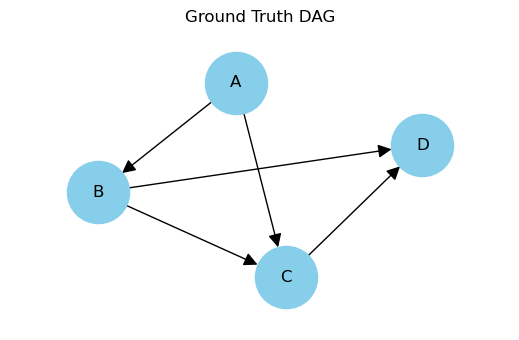

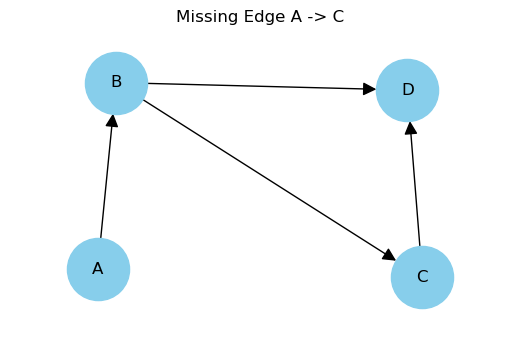

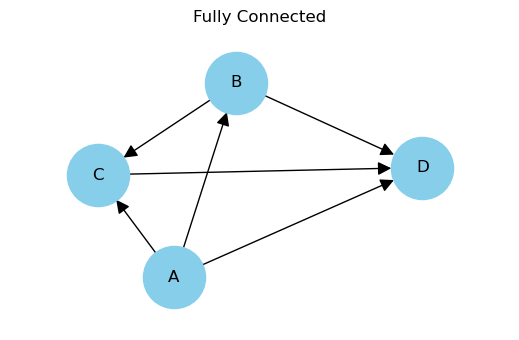

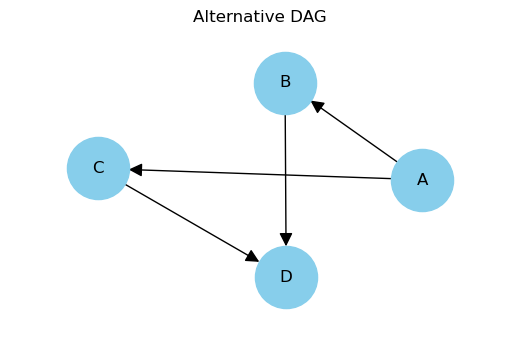

In [21]:
# Ground Truth DAG (Adj1)
Adj1 = Adj  # As defined earlier

# Missing edge A->C (Adj2)
Adj2 = np.array([
    [0, 1, 0, 0],  # A
    [0, 0, 1, 1],  # B
    [0, 0, 0, 1],  # C
    [0, 0, 0, 0],  # D
])

# Fully Connected DAG (Adj3)
Adj3 = np.array([
    [0, 1, 1, 1],  # A
    [0, 0, 1, 1],  # B
    [0, 0, 0, 1],  # C
    [0, 0, 0, 0],  # D
])

# Alternative DAG (Adj4) - Remove edge B->C
Adj4 = np.array([
    [0, 1, 1, 0],  # A
    [0, 0, 0, 1],  # B
    [0, 0, 0, 1],  # C
    [0, 0, 0, 0],  # D
])

# Dictionary of candidate DAGs
candidate_DAGs = {
    'Ground Truth DAG': Adj1,
    'Missing Edge A->C': Adj2,
    'Fully Connected DAG': Adj3,
    'Alternative DAG': Adj4
}

node_labels = ['A', 'B', 'C', 'D']


plot_graph_from_adj_mat(Adj1, node_labels, title="Ground Truth DAG")
plot_graph_from_adj_mat(Adj2, node_labels, title = "Missing Edge A -> C")
plot_graph_from_adj_mat(Adj3, node_labels, title = 'Fully Connected')
plot_graph_from_adj_mat(Adj4, node_labels, title = 'Alternative DAG')

## Computing BGe Scores
We need to adjust the BGeScore Class slightly, compared to what is provided in the `StructureMCMC` repo so that when we change the `am` hyperparameter, it reclaculates the dependent paratmeters.

In [14]:

def node_label_to_index(node_labels):
    """
    Creates a mapping from node labels to their indices.
    
    Parameters:
        node_labels (list): List of node labels.
        
    Returns:
        dict: Dictionary mapping node labels to indices.
    """
    return {label: idx for idx, label in enumerate(node_labels)}

def find_parents(adj_matrix, node_index):
    """
    Find the indices of parent nodes for a given node in a directed graph.

    Parameters:
        adj_matrix (numpy.ndarray): adjacency matrix of the graph
        node_index (int): index of the node to find parents for

    Returns:
        list: list of indices of parent nodes of the specified node
    """
    # In the adjacency matrix, adj_matrix[i, j] == 1 means an edge from node i to node j
    parent_indices = np.where(adj_matrix[:, node_index] == 1)[0]
    return parent_indices.tolist()

class Score(ABC):
    """
    Base class for graph scores for structure learning using MCMC.
    Inheriting classes must implement the following methods:
        compute() -> dict
        compute_local() -> dict
    """
    def __init__(self, data : pd.DataFrame, incidence : np.ndarray,\
                 to_string : str, is_log_space = True):
        """
        Initializes the Score abstract class.
        All classes that inherit from this class must implement the compute method.

        Parameters:
            data (pd.DataFrame):            dataset
            incidence (np.ndarray):         adjacency matrix of the graph
            to_string (str):                string representation of the score
            is_log_space (bool):            indicates if computations are done in log space
        """
        self._data = data
        self._node_labels = list(data.columns)
        self._adj_matrix = incidence
        self._node_label_to_index = node_label_to_index(self._node_labels)
        self._is_log_space = is_log_space

        self._to_string = to_string

    # abstract method to be implemented by subclasses
    @abstractmethod
    def compute(self):
        """
        Implements a score function (e.g., BGe, Marginal Likelihood, etc)
        """
        pass

    @abstractmethod
    def compute_local(self, node : str, parents: list):
        """
        Implements a score function (e.g., BGe, Marginal Likelihood, etc) for a specific node
        """
        pass

    def __str__(self):
        """
        Return a string representation of this score instance
        """
        return self._to_string

    @property
    def to_string(self):
        return self._to_string

    @to_string.setter
    def to_string(self, string):
        self._to_string = string

    @property
    def data(self):
        return self._data

    @data.setter
    def data(self, d):
        self._data = d

    @property
    def adj_matrix(self):
        """
        Adjacency matrix. adj_matrix and incidence refer to the same numpy.ndarray.
        """
        return self._adj_matrix

    @adj_matrix.setter
    def adj_matrix(self, mat):
        """
        Set adjacency matrix for scoring.
        """
        self._adj_matrix = mat

    @property
    def incidence(self):
        """
        Adjacency matrix. adj_matrix and incidence refer to the same numpy.ndarray.
        """
        return self._adj_matrix

    @incidence.setter
    def incidence(self, mat):
        """
        Set adjacency matrix for scoring.
        """
        self._adj_matrix = mat

    @property
    def is_log_space(self):
        return self._is_log_space

    @is_log_space.setter
    def is_log_space(self, log_space: bool):
        self._is_log_space = log_space

    @property
    def node_labels(self):
        return self._node_labels

    @property
    def node_label_to_index(self):
        """
        Return mapping of node labels to indices
        """
        return self._node_label_to_index

class BGeScore(Score):
    """
    BGe (Bayesian Gaussian Equivalent) Score
    The implementation of the BGe score comes from:
    [1] Kuipers, Moffa, and Heckerman - 2014 - Addendum on the Scoring of Gaussian Directed Acyclic Graphical Models
    """
    def __init__(self, data : pd.DataFrame, incidence : np.ndarray, is_log_space = True):
        """
        Initialize BGeScore instance.

        Parameters:
            data (pandas.DataFrame): data
            incidence (numpy.ndarray): graph adjacency matrix
            is_log_space (bool): indicates if computations are done in log space
        """
        super().__init__(data, incidence, "BGe Score", is_log_space)

        self._num_cols = data.shape[1]  # number of variables
        self._num_obvs = data.shape[0]  # number of observations
        self._mu0 = np.zeros(self._num_cols)  # Prior mean, initialized as a zero vector 

        # Scoring parameters.
        self._am = 1  # Default value for alpha_mu
        self._aw = self._num_cols + self._am + 1  # Degrees of freedom 
        self._recompute_parameters()

        self._parameters = {}
        self._reg_coefficients = {}

    def _recompute_parameters(self):
        """
        Recompute parameters that depend on the hyperparameter am.
        """
        T0scale = self._am * (self._aw - self._num_cols - 1) / (self._am + 1)
        self._t = T0scale
        self._T0 = T0scale * np.eye(self._num_cols)
        data_mean = np.mean(self.data.values, axis=0)
        self._TN = (
            self._T0
            + (self._num_obvs - 1) * np.cov(self.data.T, bias=True)
            + ((self._am * self._num_obvs) / (self._am + self._num_obvs))
            * np.outer((self._mu0 - data_mean), (self._mu0 - data_mean))
        )

        self._awpN = self._aw + self._num_obvs
        self._constscorefact = (
            - (self._num_obvs / 2) * np.log(np.pi)
            + 0.5 * np.log(self._am / (self._am + self._num_obvs))
        )
        self._scoreconstvec = np.zeros(self._num_cols)
        for i in range(self._num_cols):
            awp = self._aw - self._num_cols + i + 1
            self._scoreconstvec[i] = (
                self._constscorefact
                - lgamma(awp / 2)
                + lgamma((awp + self._num_obvs) / 2)
                + (awp + i) / 2 * np.log(self._t)
            )

    def compute(self):
        """
        Compute the BGe score for the entire graph.

        Returns:
            dict: Total score and parameters
        """
        return self.compute_BGe_with_graph()

    def compute_node(self, node : str):
        """
        Compute the BGe score for a single node.

        Parameters:
            node (str): node label

        Returns:
            dict: Score and parameters for the node
        """
        return self.compute_BGe_with_node(node)

    def compute_BGe_with_graph(self):
        """
        Compute the BGe score for the entire graph.

        Returns:
            dict: Total score and parameters
        """
        total_log_ml = 0
        parameters = {}  # Dictionary to store the parameters for each node

        # Loop through each node in the graph
        for node in self.node_labels:
            result = self.compute_BGe_with_node(node)
            log_ml_node = result['score']

            # Save the parameters for the node
            parameters[node] = {
                'score': log_ml_node,
                'parents': find_parents(self.incidence, self.node_label_to_index[node])
            }

            total_log_ml += log_ml_node

        # Save the parameters
        self._parameters = parameters

        # Return the total marginal likelihood and the parameters
        score = {
            'score': total_log_ml,
            'parameters': parameters
        }
        return score

    def compute_BGe_with_node(self, node : str):
        """
        Compute the BGe score for a single node.

        Parameters:
            node (str): node label

        Returns:
            dict: Score and parameters for the node
        """
        node_indx = self.node_label_to_index[node]
        parentnodes = find_parents(self.incidence, node_indx)
        num_parents = len(parentnodes)  # Number of parents

        awpNd2 = (self._awpN - self._num_cols + num_parents + 1) / 2

        A = self._TN[node_indx, node_indx]

        if num_parents == 0:
            # No parents
            corescore = self._scoreconstvec[num_parents] - awpNd2 * np.log(A)
        else:
            D = self._TN[np.ix_(parentnodes, parentnodes)]
            choltemp = np.linalg.cholesky(D)
            logdetD = 2 * np.sum(np.log(np.diag(choltemp)))

            B = self._TN[node_indx, parentnodes]
            cholsolve = np.linalg.solve(choltemp, B.T)
            logdetpart2 = np.log(A - np.sum(cholsolve**2))
            corescore = (
                self._scoreconstvec[num_parents]
                - awpNd2 * logdetpart2
                - logdetD / 2
            )

        # Save the parameters for the node
        parameters = {
            'parents': parentnodes
        }
        self._parameters[node] = parameters

        score = {
            'score': corescore,
            'parameters': parameters
        }

        return score

    def compute_local(self, node : str, parents: list):
        """
        Compute the BGe score for a specific node and given parents.

        Parameters:
            node (str): node label
            parents (list): node labels of parent nodes

        Returns:
            dict: Score and parameters for the node
        """
        node_indx = self.node_label_to_index[node]
        parentnodes = [self.node_label_to_index[p] for p in parents]
        num_parents = len(parentnodes)  # Number of parents

        awpNd2 = (self._awpN - self._num_cols + num_parents + 1) / 2

        A = self._TN[node_indx, node_indx]

        if num_parents == 0:
            # No parents
            corescore = self._scoreconstvec[num_parents] - awpNd2 * np.log(A)
        else:
            D = self._TN[np.ix_(parentnodes, parentnodes)]
            choltemp = np.linalg.cholesky(D)
            logdetD = 2 * np.sum(np.log(np.diag(choltemp)))

            B = self._TN[node_indx, parentnodes]
            cholsolve = np.linalg.solve(choltemp, B.T)
            logdetpart2 = np.log(A - np.sum(cholsolve**2))
            corescore = (
                self._scoreconstvec[num_parents]
                - awpNd2 * logdetpart2
                - logdetD / 2
            )

        # Save the parameters for the node
        parameters = {
            'parents': parentnodes
        }
        self._parameters[node] = parameters

        score = {
            'score': corescore,
            'parameters': parameters
        }

        return score

    @property
    def am(self):
        return self._am

    @am.setter
    def am(self, value):
        self._am = value
        # Recompute parameters that depend on am
        self._aw = self._num_cols + self._am + 1
        self._recompute_parameters()

    @property
    def parameters(self):
        return self._parameters

    @parameters.setter
    def parameters(self, params):
        self._parameters = params

    @property
    def reg_coefficients(self):
        return self._reg_coefficients

    @reg_coefficients.setter
    def reg_coefficients(self, coefficients):
        self._reg_coefficients = coefficients


## Computing the Scores
We can now compute the BGe scores for each candidate DAG

In [15]:
# Initialize a dictionary to store results
results = {}

# List of prior hyperparameter values for am
am_values = [1, 10, 100]

for am in am_values:
    print(f"\nComputing BGe scores with am = {am}")
    results[am] = {}
    for dag_name, adj in candidate_DAGs.items():
        # Instantiate BGeScore
        bge_score = BGeScore(df, adj, is_log_space=True)
        bge_score.am = am  # This will trigger recomputation of parameters
        
        # Compute the BGe score
        score_dict = bge_score.compute()
        total_score = score_dict['score']
        results[am][dag_name] = total_score
        print(f"am={am}, DAG='{dag_name}', BGe Score={total_score}")


Computing BGe scores with am = 1
am=1, DAG='Ground Truth DAG', BGe Score=-5654.989054965795
am=1, DAG='Missing Edge A->C', BGe Score=-5718.594471899767
am=1, DAG='Fully Connected DAG', BGe Score=-5659.557880654369
am=1, DAG='Alternative DAG', BGe Score=-5978.843915050938

Computing BGe scores with am = 10
am=10, DAG='Ground Truth DAG', BGe Score=-5643.27415265688
am=10, DAG='Missing Edge A->C', BGe Score=-5709.705604540932
am=10, DAG='Fully Connected DAG', BGe Score=-5645.4891056847055
am=10, DAG='Alternative DAG', BGe Score=-5968.387210230495

Computing BGe scores with am = 100
am=100, DAG='Ground Truth DAG', BGe Score=-5738.554627859782
am=100, DAG='Missing Edge A->C', BGe Score=-5811.02986822293
am=100, DAG='Fully Connected DAG', BGe Score=-5738.894637271807
am=100, DAG='Alternative DAG', BGe Score=-6055.13488924312
